# Setup

In [7]:
#%pip install einops transformers sae_lens sae_vis
import einops
import os
from utils_folder import dashboards
from transformers import AutoModel, AutoTokenizer
from sae_lens.toolkit.pretrained_saes import get_gpt2_res_jb_saes, convert_connor_rob_sae_to_our_saelens_format, download_sae_from_hf
import numpy as np
from matplotlib.colors import LogNorm, Normalize
import pandas as pd
import seaborn as sns
import torch as t
import plotly_express as px
import matplotlib.pyplot as plt
import matplotlib as mpl
from tqdm.notebook import tqdm
from scipy import stats
from torch.utils.data import Dataset
from sae_vis.model_fns import AutoEncoderConfig, AutoEncoder
from transformer_lens import utils as tl_utils
from transformer_lens.hook_points import (
    HookPoint,
)

from transformer_lens import HookedTransformer, HookedTransformerConfig
from transformer_lens.utils import (
    load_dataset,
    tokenize_and_concatenate,
    download_file_from_hf,
)

from torch.utils.data import DataLoader
from transformers import DataCollatorForLanguageModeling
device = t.device("cuda" if t.cuda.is_available() else "cpu")
from transformer_lens import HookedSAE, HookedSAEConfig
from transformer_lens.utils import download_file_from_hf


from importlib import reload
from utils_folder.autoencoder import AutoEncoder
import matplotlib as mpl
cmap = mpl.colormaps["Spectral"]

from utils_folder import SAE_metrics
from utils_folder import vector_metrics
from utils_folder import misc_utils

import torch 
reload(SAE_metrics)
reload(vector_metrics)


<module 'utils_folder.vector_metrics' from '/home/ubuntu/brianna-chrisman/MATS-2024/utils_folder/vector_metrics.py'>

# Load SAE, Data, Model

In [8]:
auto_encoder_run = "concat-z-gelu-21-l1-lr-sweep-3/gelu-2l_L1_Hcat_z_lr1.00e-03_l12.00e+00_ds16384_bs4096_dc1.00e-07_rie50000_nr4_v78"
sae = AutoEncoder.load_from_hf(auto_encoder_run)
model = HookedTransformer.from_pretrained("gelu-2l").to(device)


# Load Pile data
data = load_dataset("NeelNanda/pile-10k", split="train")
tokenized_data = tokenize_and_concatenate(data, model.tokenizer, max_length=32)
tokenized_data = tokenized_data.shuffle(42)
all_tokens = tokenized_data["tokens"][:20000]

dataset = misc_utils.TokenDataset(all_tokens)
del tokenized_data, data, all_tokens

{'act_name': 'blocks.1.attn.hook_z',
 'act_size': 512,
 'anthropic_resample_last': 25000,
 'batch_size': 4096,
 'beta1': 0.9,
 'beta2': 0.99,
 'buffer_batches': 12288,
 'buffer_mult': 384,
 'buffer_size': 1572864,
 'concat_heads': True,
 'dead_direction_cutoff': 1e-07,
 'device': 'cuda',
 'dict_mult': 32,
 'dict_size': 16384,
 'enc_dtype': 'fp32',
 'head': 'cat',
 'l1_coeff': 2.0,
 'layer': 1,
 'lr': 0.001,
 'model_batch_size': 512,
 'model_name': 'gelu-2l',
 'name': 'gelu-2l_1_16384_z',
 'num_resamples': 4,
 'num_tokens': 2000000000,
 're_init_every': 50000,
 'reinit': 'reinit',
 'resample_factor': 0.01,
 'save_state_dict_every': 50000,
 'seed': 49,
 'seq_len': 128,
 'site': 'z',
 'wandb_entity': 'ckkissane',
 'wandb_project_name': 'concat-z-gelu-21-l1-lr-sweep-3'}
Loaded pretrained model gelu-2l into HookedTransformer
Moving model to device:  cuda


# Contributions

## According to W_dec

In [67]:
# Split tensor into 8 equal parts

W_dec_splits = torch.split(sae.W_dec, model.cfg.d_head, dim=1)

# Turn list of tensors into a single tenso
W_dec_splits = torch.stack(W_dec_splits, dim=0)
W_dec_contributions = (W_dec_splits**2).sum(dim=2)
W_dec_contributions = W_dec_contributions/W_dec_contributions.sum(dim=0, keepdim=True)
W_dec_contributions.shape

torch.Size([8, 16384])

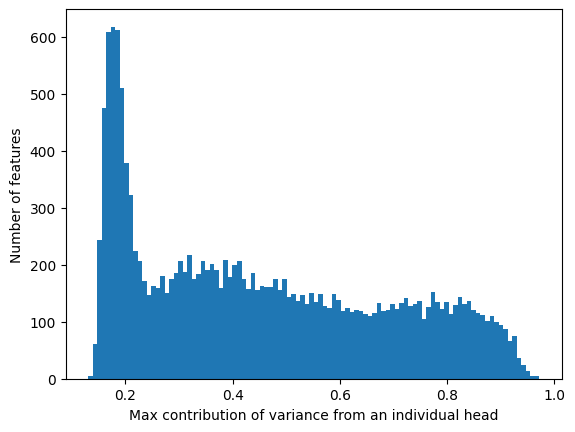

In [68]:
plt.hist(W_dec_contributions.max(dim=0).values.cpu().detach().numpy(), bins=100)
plt.xlabel('Max contribution of variance from an individual head')
plt.ylabel('Number of features')
plt.show()

The histrogram of W_dec variance is almost trimodal. There is a large set of features that are split across many heads. And then maybe another peark at .4 and .8.

In [83]:
split_across_heads = W_dec_contributions.max(dim=0).values.argsort()[:3]
in_a_single_head = W_dec_contributions.max(dim=0).values.argsort(descending=True)[:3]

In [ ]:
for i in split_across_heads:
    dashboards.get_model_card(i.item(), torch.stack([i for i,_ in dataset]), sae, model, 1, max_batch_size=32)

Hmm. The features that are split across heads seem quite uninterpretable, and have very low activations. 

In [ ]:
for i in in_a_single_head:
    dashboards.get_model_card(i.item(), torch.stack([i for i,_ in dataset]), sae, model, 1, max_batch_size=32)

Features in one head seem a lot better.

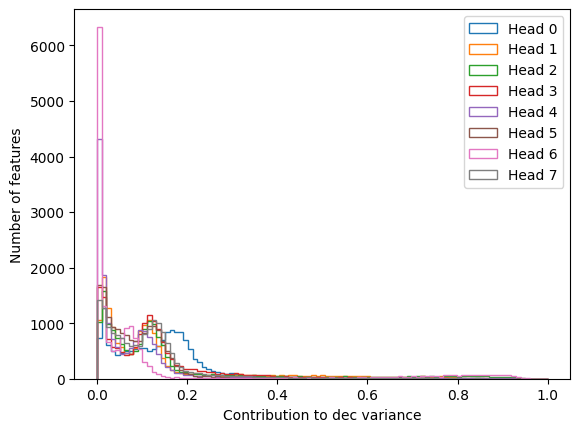

In [209]:
# Make a histogram of each head's contribution to the variance of the weights
for i in range(W_dec_contributions.shape[0]):
    plt.hist(W_dec_contributions[i,:].cpu().detach().numpy().flatten(),label=f'Head {i}', histtype='step', fill=False, bins=np.linspace(0, 1, 100))
plt.xlabel('Contribution to dec variance')
plt.ylabel('Number of features')
plt.legend()
plt.show()

Three types of heads here: Head 0, head 4/6, head 1/2/3/5/7

## According to real world activations

# Look at Activation Contributions

In [150]:
# Make a hook function that calculates the contributions of each head to the feature activation.
W_enc_split = torch.split(sae.W_enc, model.cfg.d_head, dim=0)
W_enc_split = torch.stack(W_enc_split, dim=1)

b_dec_split = torch.split(sae.b_dec, model.cfg.d_head, dim=0)
b_dec_split = torch.stack(b_dec_split, dim=1).transpose(0,1)
activations_all = []

sum_variance = torch.zeros(model.cfg.n_heads, sae.cfg['dict_size']).to(device)
def SAE_hook(
    activations, #: torch.float[torch.Tensor, "batch seq_len n_head d_head "],
    hook: HookPoint,
):
    global sum_variance
    dot_prods = einops.einsum(W_enc_split, activations-b_dec_split,
                  "d_head n_head n_features, batch seq_len n_head d_head -> batch seq_len n_head n_features")
    mask = (dot_prods.sum(dim=2, keepdim=False)+sae.b_enc)<=0
    expanded_mask = einops.repeat(mask, "batch seq_len n_features -> batch seq_len n_head n_features", n_head=model.cfg.n_heads)
    dot_prods[expanded_mask] = 0
    
    # Don't compute contributions where the feature wasn't activated.
    sum_variance = sum_variance + (dot_prods**2).sum(dim=0).sum(dim=0)


for tokens, i in tqdm(DataLoader(dataset, batch_size=128, shuffle=True)):
    model.run_with_hooks(
        tokens, 
        return_type=None, # For efficiency, we don't need to calculate the logits
        fwd_hooks=[(
            sae.cfg["act_name"],
            SAE_hook
        )]
    )

# remove hook from model
model.remove_hooks()

  0%|          | 0/157 [00:00<?, ?it/s]

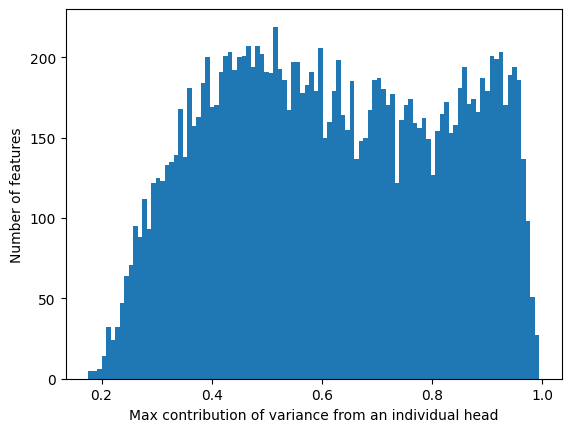

In [151]:
activation_contributions = sum_variance/sum_variance.sum(dim=0, keepdim=True)
plt.hist(activation_contributions.max(dim=0).values.cpu().detach().numpy(), bins=100)
plt.xlabel('Max contribution of variance from an individual head')
plt.ylabel('Number of features')
plt.show()

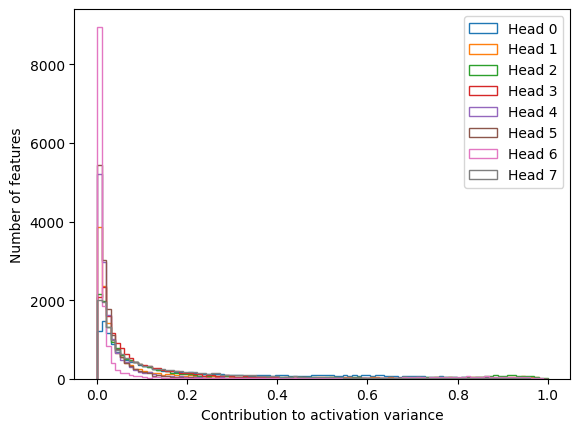

In [276]:
# Make a histogram of each head's contribution to the variance of the weights
for i in range(activation_contributions.shape[0]):
    plt.hist(activation_contributions[i,:].cpu().detach().numpy().flatten(),label=f'Head {i}', histtype='step', fill=False, bins=np.linspace(0, 1, 100))
plt.xlabel('Contribution to activation variance')
plt.ylabel('Number of features')
plt.legend()
plt.show()

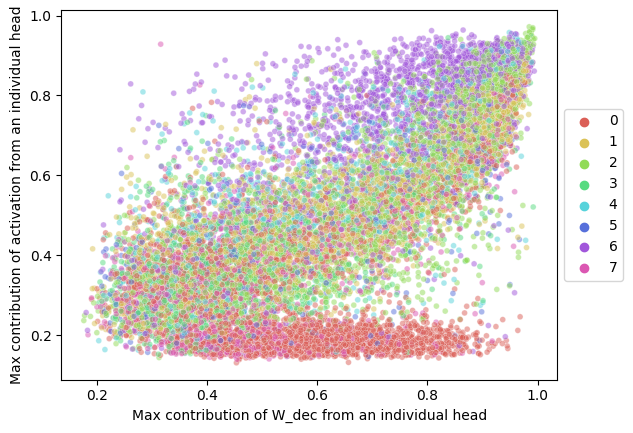

In [205]:
x = activation_contributions.max(dim=0).values
hue = activation_contributions.argmax(dim=0)
y = W_dec_contributions.max(dim=0).values
import seaborn as sns

# Generate a list of colors for the discrete color scale
num_categories = model.cfg.n_heads
colors = sns.color_palette("hls", num_categories)

# Plot the data using the discrete color scale
sns.scatterplot(x=x.cpu().detach().numpy(), y=y.cpu().detach().numpy(), hue=hue.cpu().detach().numpy(), palette=colors, size=0.05, alpha=0.5)

# Move the legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.3))
# Remove the last item on the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:-1], labels[:-1], title='', loc='center left', bbox_to_anchor=(1, 0.5))
# Show the plot

plt.xlabel('Max contribution of W_dec from an individual head')
plt.ylabel('Max contribution of activation from an individual head')
plt.show()


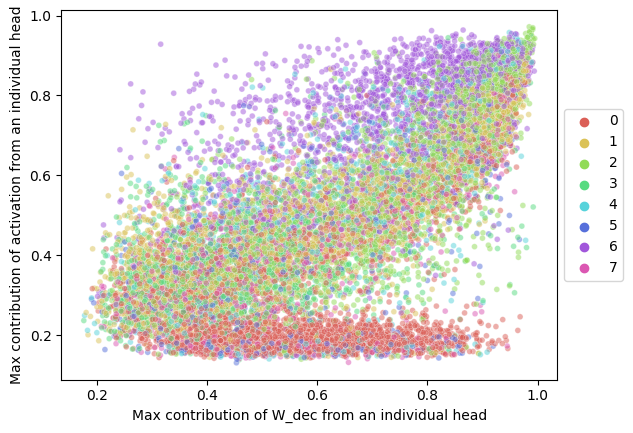

In [207]:
x = activation_contributions.max(dim=0).values
hue = W_dec_contributions.argmax(dim=0)
y = W_dec_contributions.max(dim=0).values
import seaborn as sns

# Generate a list of colors for the discrete color scale
num_categories = model.cfg.n_heads
colors = sns.color_palette("hls", num_categories)

# Plot the data using the discrete color scale
sns.scatterplot(x=x.cpu().detach().numpy(), y=y.cpu().detach().numpy(), hue=hue.cpu().detach().numpy(), palette=colors, size=0.05, alpha=0.5)

# Move the legend to the right of the plot
plt.legend(loc='center left', bbox_to_anchor=(1, 0.3))
# Remove the last item on the legend
handles, labels = plt.gca().get_legend_handles_labels()
plt.legend(handles[:-1], labels[:-1], title='', loc='center left', bbox_to_anchor=(1, 0.5))
# Show the plot

plt.xlabel('Max contribution of W_dec from an individual head')
plt.ylabel('Max contribution of activation from an individual head')
plt.show()


There are a set of features that are interesting here. It is a set of features that are almost entirely split across heads according to W_dec. But when you go to the activation space, it is almost entirely head 0 that is activating them.

Let's take a look at some of these features. 

In [ ]:
interesting_features = torch.where((x>.5) & (y<.2) & (hue==0))[0][:3]
for i in interesting_features:
    dashboards.get_model_card(i.item(), torch.stack([i for i,_ in dataset]), sae, model, 1, max_batch_size=32)

It seems that these are very weak features. Their max activations are low and they aren't terribly interpretable.

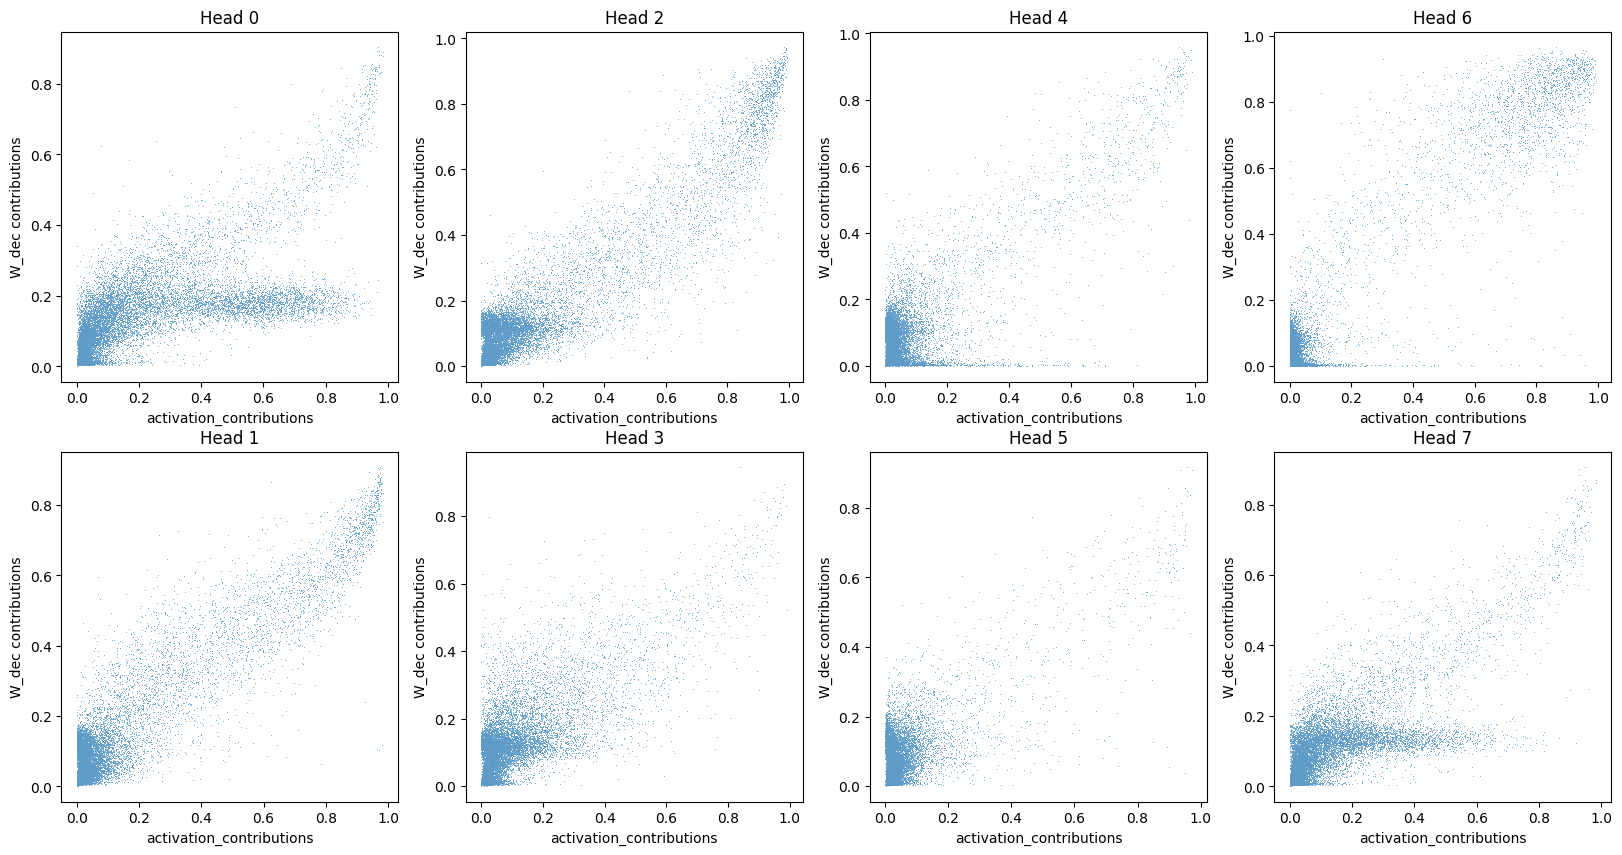

In [153]:
# Make 8 scatter plots, one in each subplot of a 4 x 2 grid
# of the activation contributions vs the W_dec contributions, one for each head
fig, axs = plt.subplots(2, 4, figsize=(20, 10))
for i in range(8):
    sns.scatterplot(x=activation_contributions[i,:].cpu().numpy(), y=W_dec_contributions[i,:].cpu().numpy(), s=.5, ax=axs[i%2,i//2])
    axs[i%2,i//2].set_title(f'Head {i}')
    axs[i%2,i//2].set_xlabel('activation_contributions')
    axs[i%2,i//2].set_ylabel('W_dec contributions')


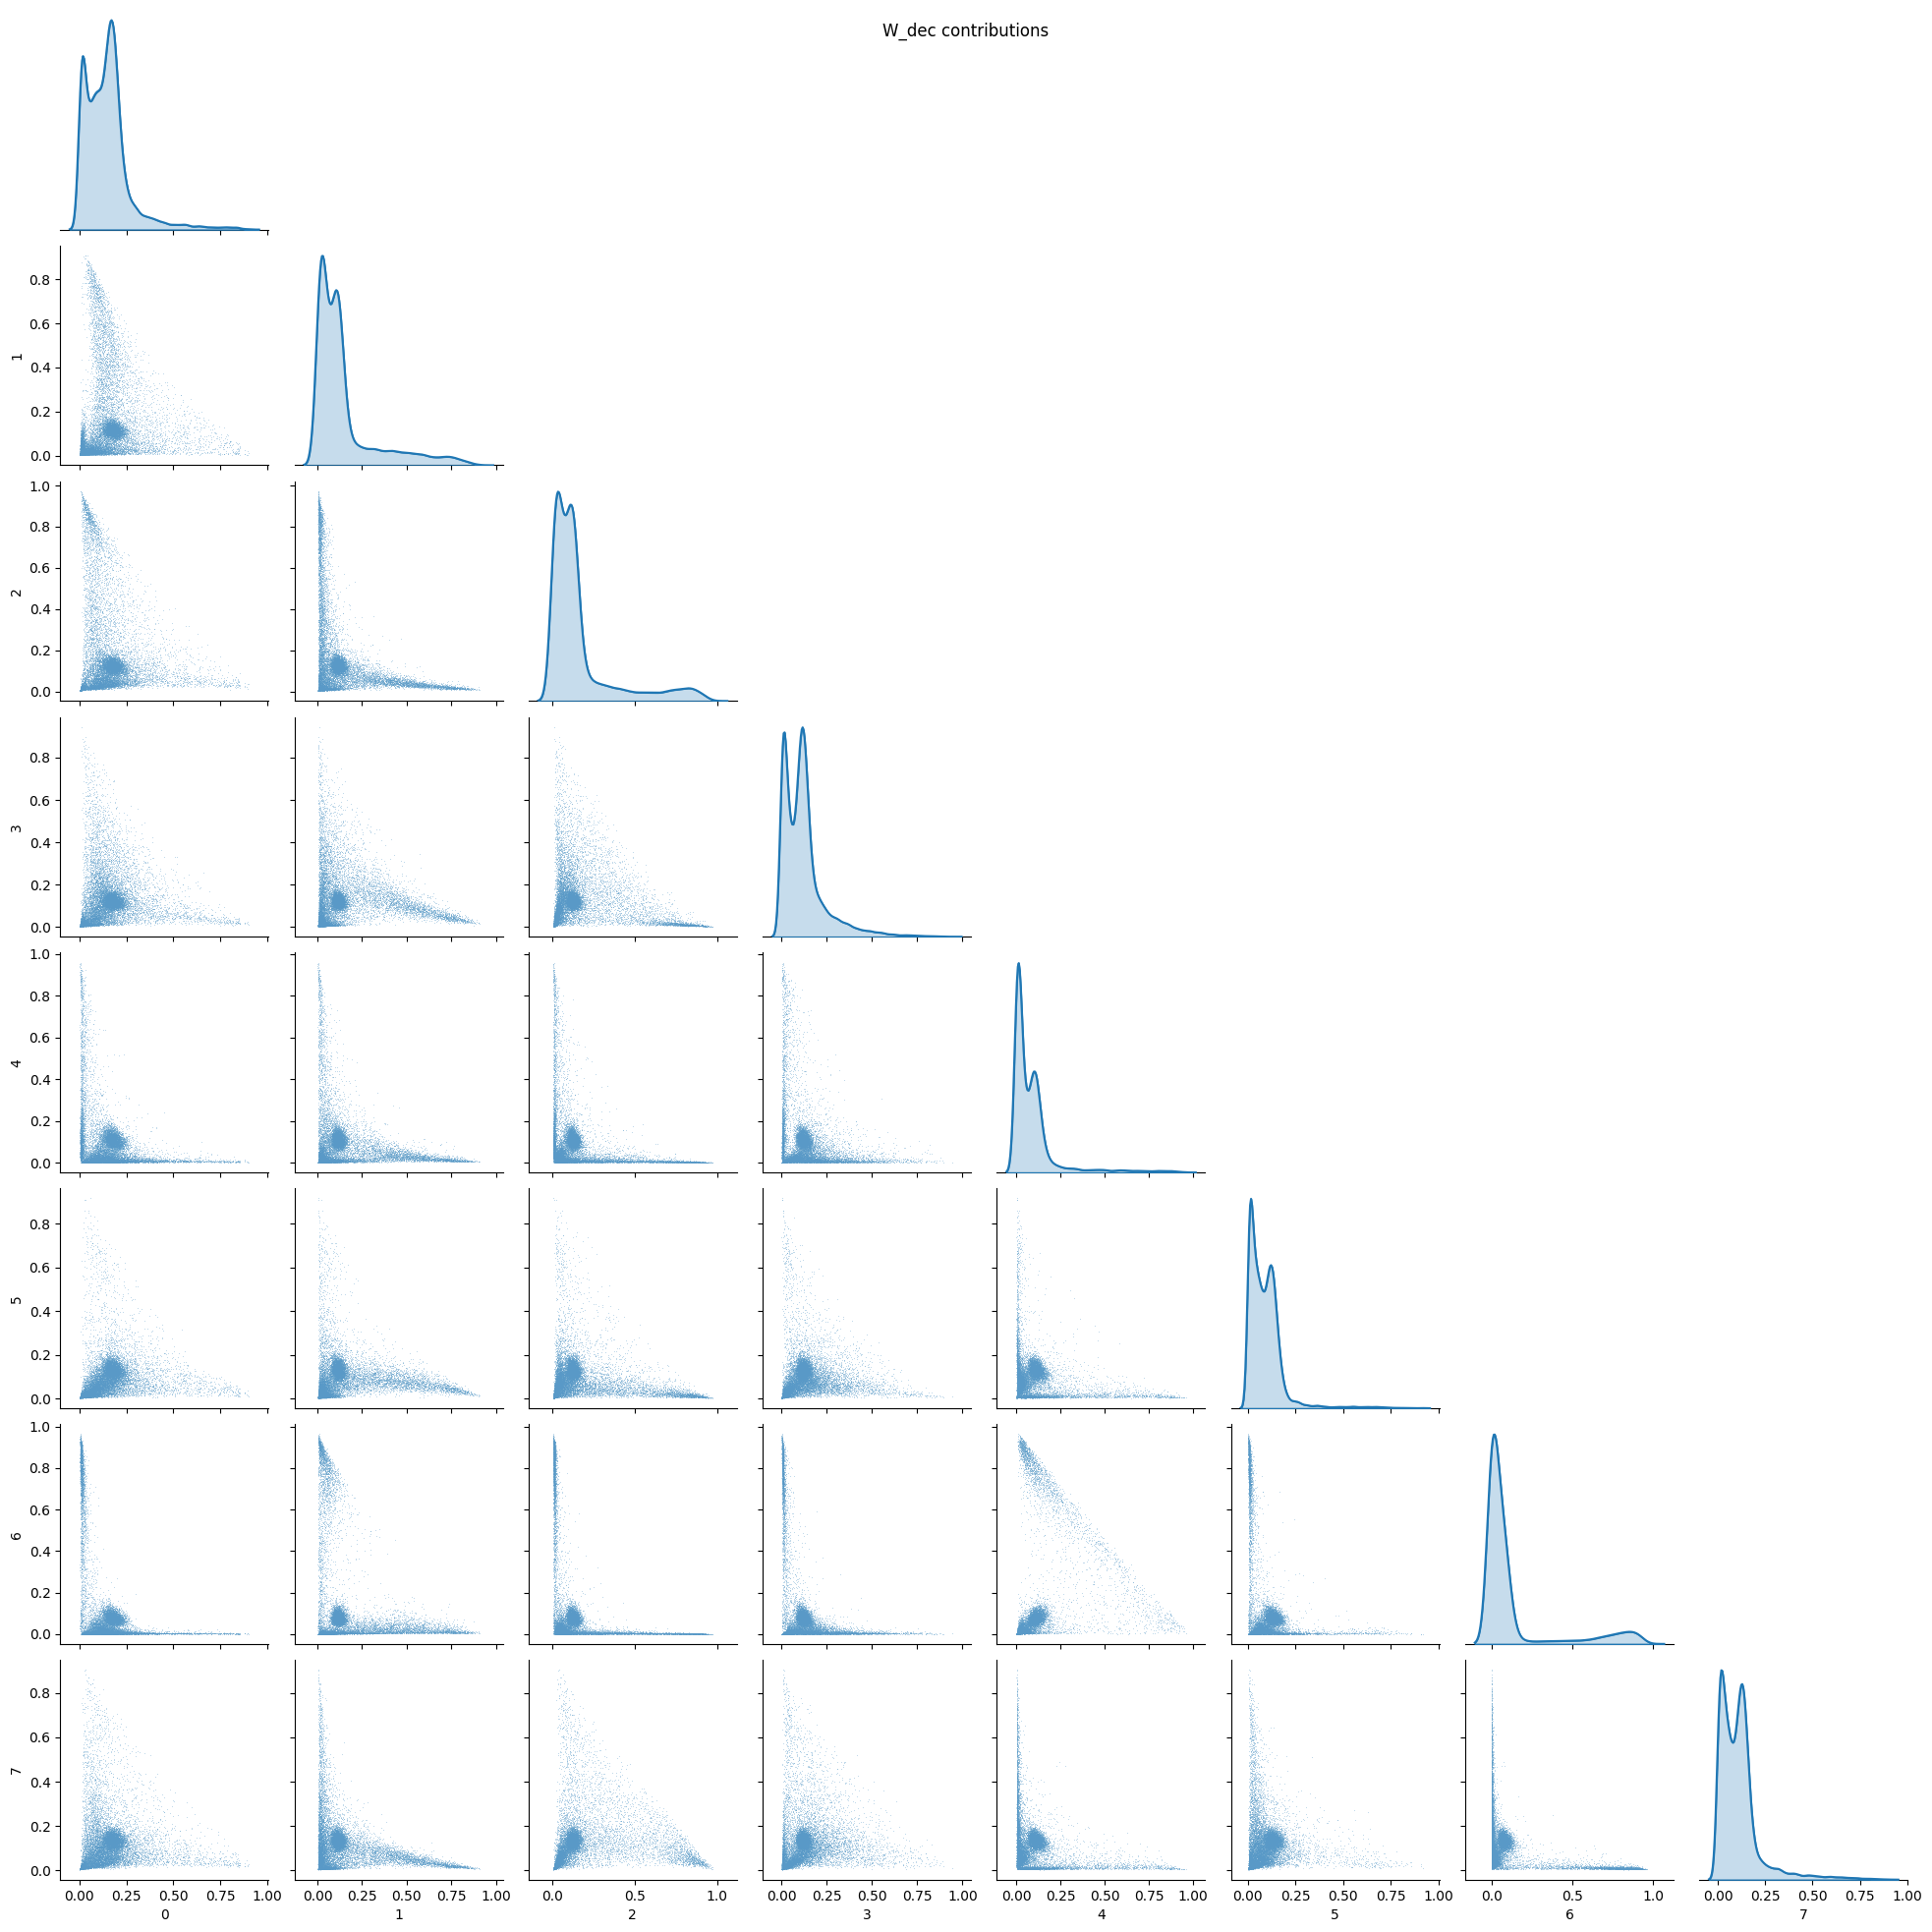

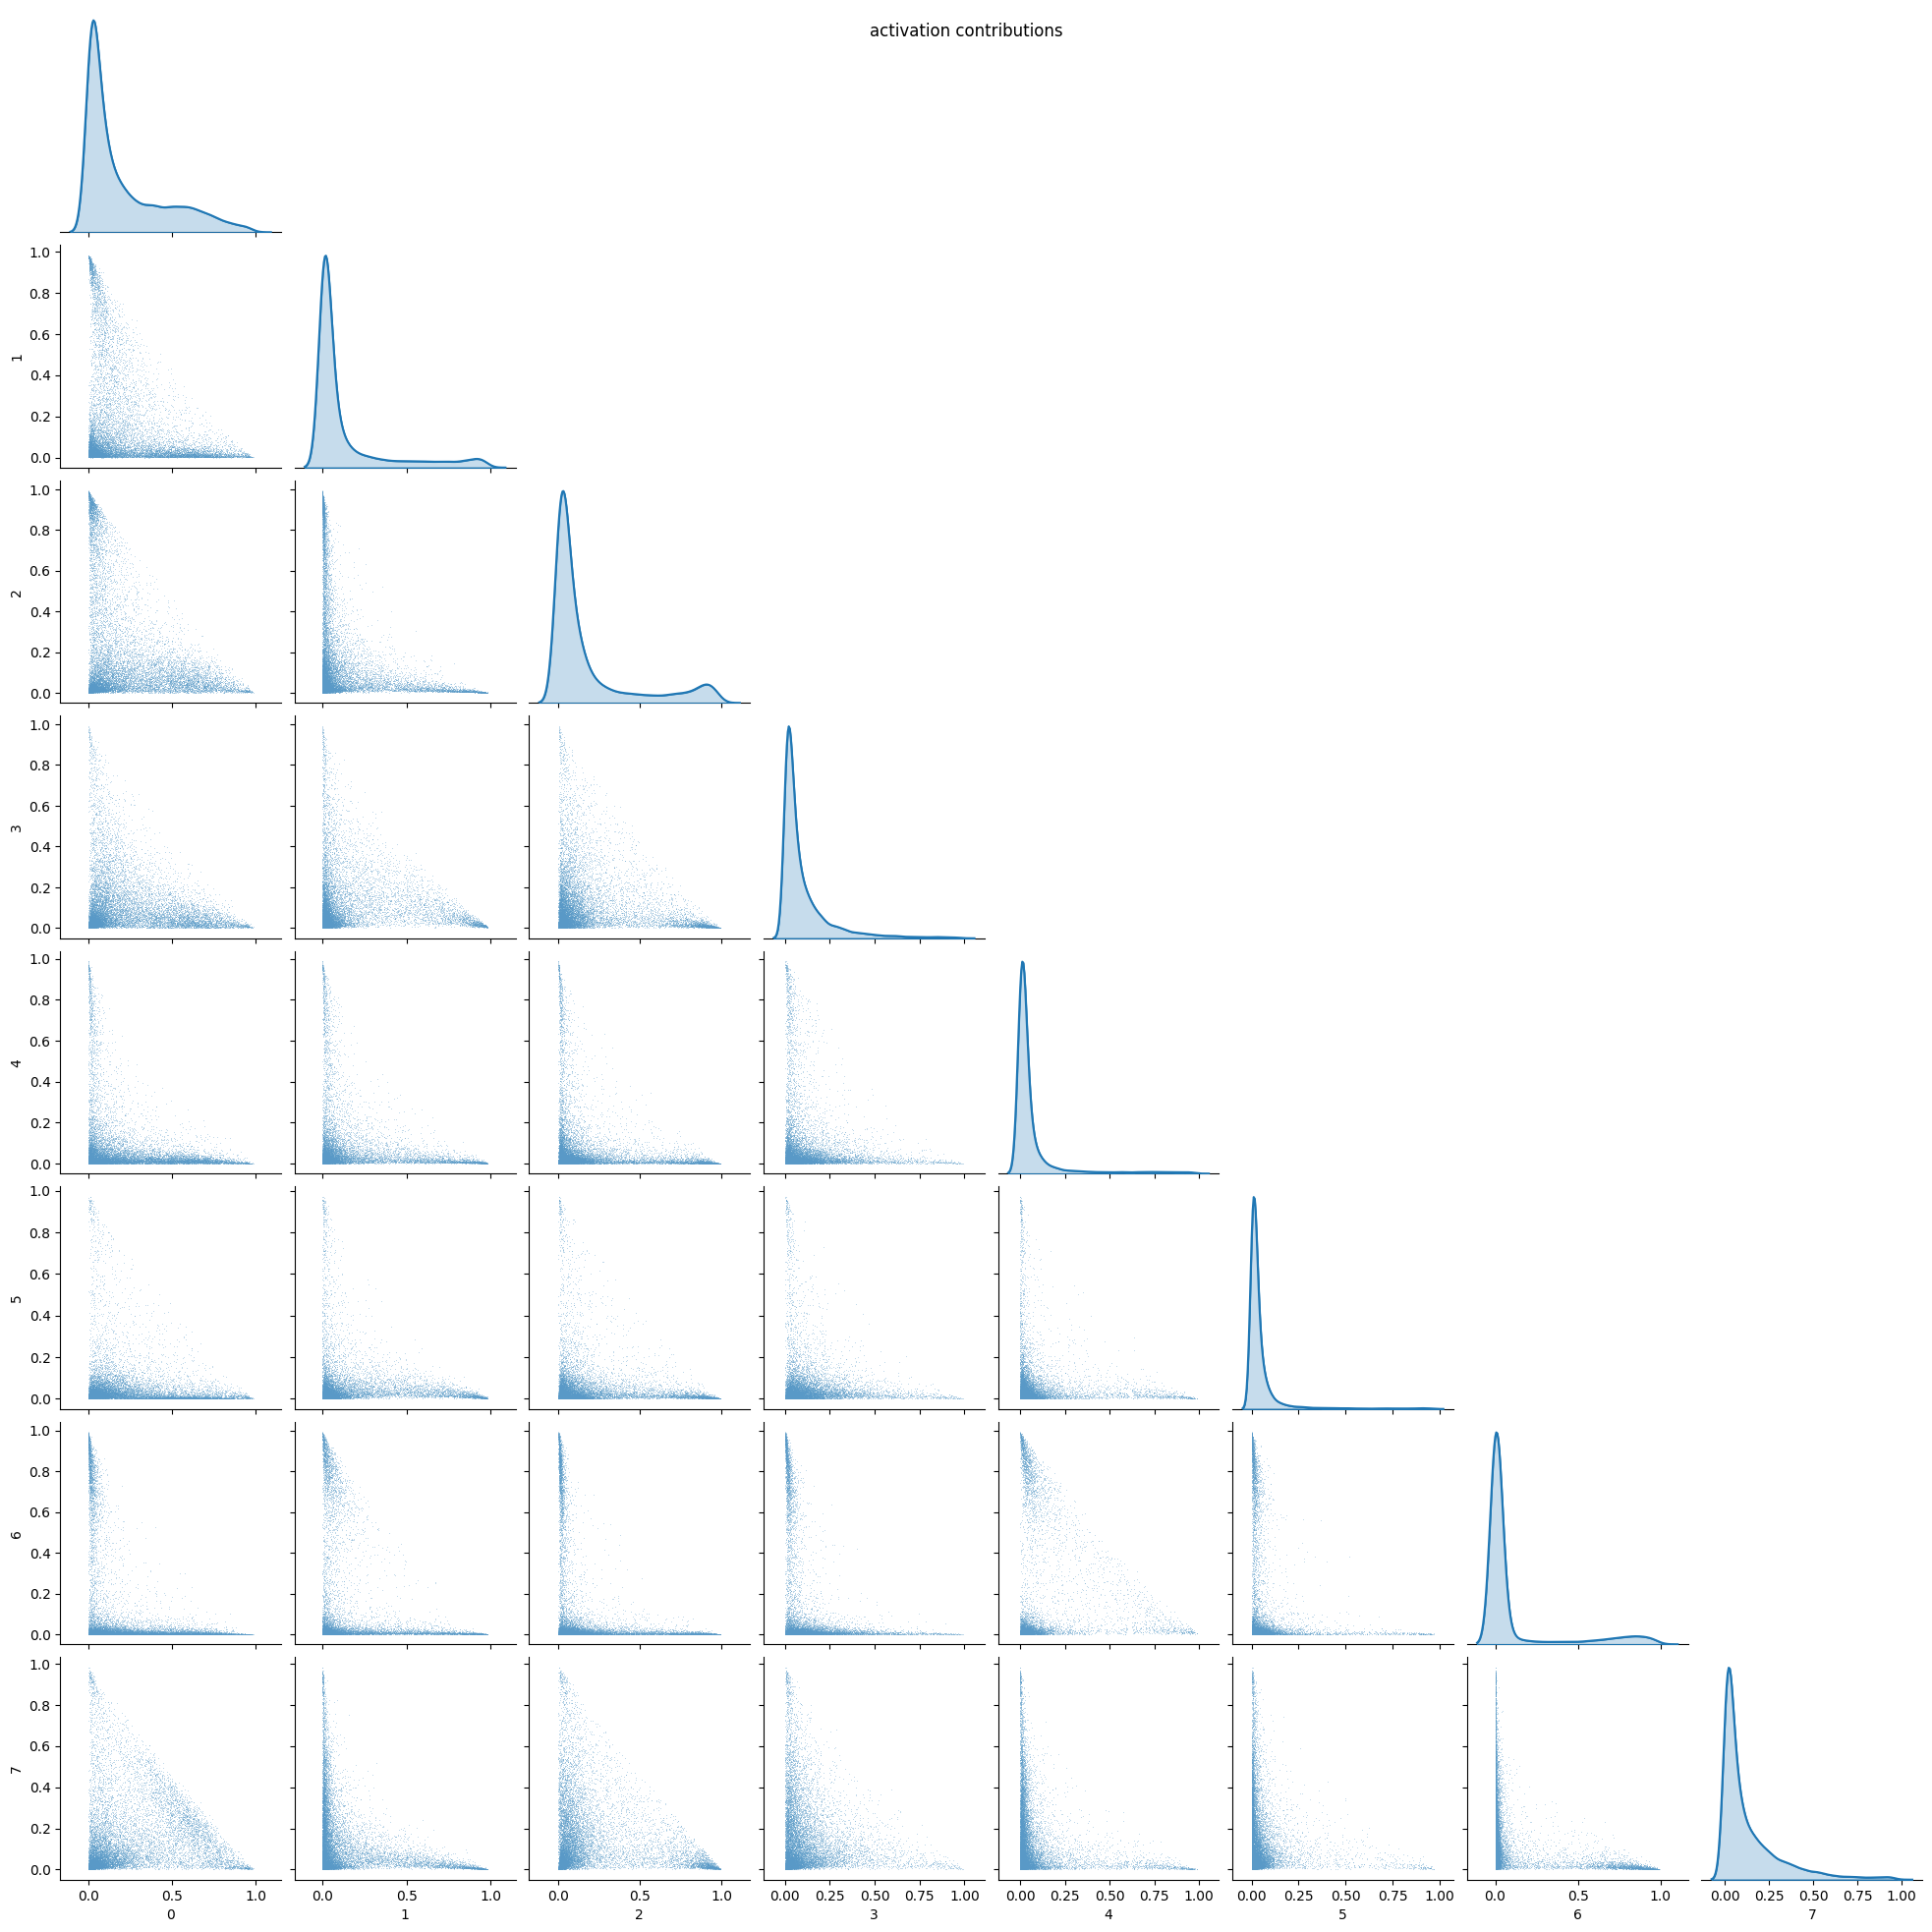

In [208]:
to_plot = pd.DataFrame(W_dec_contributions.transpose(1,0).cpu().numpy())
g = sns.pairplot(to_plot, plot_kws={"s": .2}, diag_kind="kde", corner=True)
g.map_diag(sns.kdeplot)
plt.suptitle('W_dec contributions')
plt.show()


to_plot = pd.DataFrame(activation_contributions.transpose(1,0).cpu().numpy())
g = sns.pairplot(to_plot, plot_kws={"s": .2}, diag_kind="kde", corner=True)
g.map_diag(sns.kdeplot)
plt.suptitle('activation contributions')
plt.show()

In [214]:
cosine_sims = sae.W_dec @ sae.W_dec.T

cosine_sims = cosine_sims - torch.diag(cosine_sims.diag())
max_cosine_sim = abs(cosine_sims).max(dim=0)

In [ ]:
cosine_sims[torch.diag(cosine_sims.diag())]

# Interference between SAE features

## Pre-W_o

In [ ]:
cosine_sims_concat = sae.W_dec @ sae.W_dec.T
# Set diagonal components to Nan

cosine_sims_concat = cosine_sims_concat.flatten()
cosine_sims_concat.shape


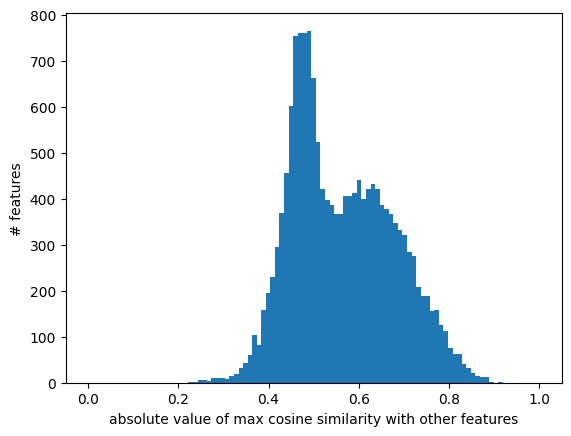

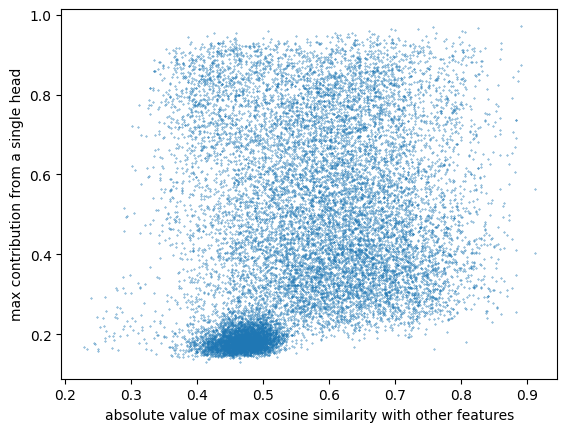

In [279]:
cosine_sims_concat = sae.W_dec @ sae.W_dec.T

# Set diagonal components to zero
cosine_sims_concat = cosine_sims_concat - torch.diag(cosine_sims_concat.diag())
max_cosine_sim_concat = abs(cosine_sims_concat).max(dim=0)
plt.hist(max_cosine_sim_concat.values.cpu().detach().numpy(), bins=np.linspace(0,1,100))
plt.xlabel('absolute value of max cosine similarity with other features')
plt.ylabel('# features')
plt.show()


# Set diagnoals of cosine_sims_concat to nan


cosine_sims_concat = cosine_sims_concat - torch.diag(cosine_sims_concat.diag())
max_cosine_sim_concat = abs(cosine_sims_concat).flatten()
plt.hist(max_cosine_sim_concat.values.cpu().detach().numpy(), bins=np.linspace(0,1,100))
plt.xlabel('absolute value of max cosine similarity with other features')
plt.ylabel('# features')
plt.show()


plt.scatter(max_cosine_sim_concat.values.cpu().detach().numpy(), W_dec_contributions.max(dim=0).values.cpu().detach().numpy(), s=.1)
plt.xlabel('absolute value of max cosine similarity with other features')
plt.ylabel('max contribution from a single head')
plt.show()

In [283]:
# Get named parameters from HookedTransformer
W_O = model.get_parameter('blocks.1.attn.W_O')
W_O_concat = W_O.flatten(0,1)

feature_W_O_dir = sae.W_dec @ W_O_concat
# Normalize feature_W_O_dir to a set of unit vectors
feature_W_O_dir = feature_W_O_dir / feature_W_O_dir.norm(dim=1, keepdim=True)

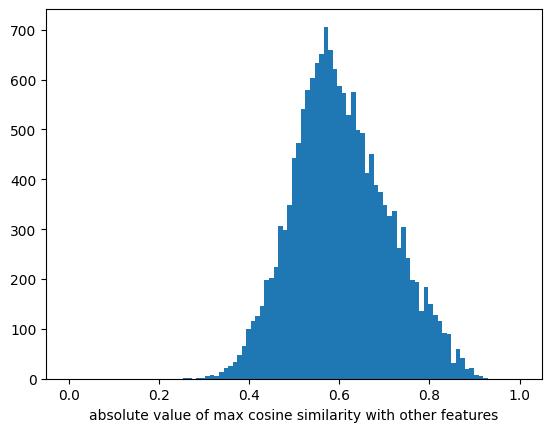

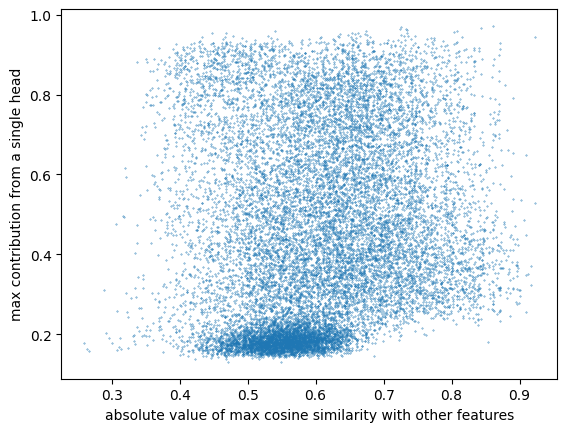

In [ ]:
cosine_sims_W_o = feature_W_O_dir @ feature_W_O_dir.T

# Set diagonal components to zero
cosine_sims_W_o = cosine_sims_W_o - torch.diag(cosine_sims_W_o.diag())
max_cosine_sim_W_o = abs(cosine_sims_W_o).max(dim=0)
plt.hist(max_cosine_sim_W_o.values.cpu().detach().numpy(), bins=np.linspace(0,1,100))
plt.xlabel('absolute value of max cosine similarity with other features')
plt.show()


plt.scatter(max_cosine_sim_W_o.values.cpu().detach().numpy(), W_dec_contributions.max(dim=0).values.cpu().detach().numpy(), s=.1)
plt.xlabel('absolute value of max cosine similarity with other features')
plt.ylabel('max contribution from a single head')
plt.show()

In [ ]:
plt.scatter(max_cosine_sim_concat.values.cpu().detach().numpy(), max_cosine_sim_W_o.values.cpu().detach().numpy(), s=.1)
plt.xlabel('Connor-space max cosine similarity')
plt.ylabel('W_o space max cosine similarity')
plt.show()

# W_O